# Neural Style Transfer

This notebook implements deep CNN based image style transfer algorithm from ["Image Style Transfer Using Convolutional Neural Networks" (Gatys et al., CVPR 2016)](http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7780634).

The proposed technique takes two images as input, i.e. a content image (generally a photograph) and a style image (generally an artwork painting). Then, it produces an output image such that the content(objects in the image) resembles the "content image" whereas the style i.e. the texture is similar to the "style image". In order words, it re-draws the "content image" using the artistic style of the "style image".

Matching the style and content of the generated image with the input image is achieved by minimizing a loss function that is based on the feature representations of the images. The representations are computed using the features(filter activations) obtained from different layers of a pre-trained VGG_16 network as suggested in the paper. Note that this network is only used for feature extraction and not trained further at all. First, the new image is initialized as Gaussian (White) Noise matrix whose shape is the same as the content image. Then, it is passed through the VGG network and its feature representations are recorded at the end of various layers of the network. Similarly, the content and style images are also passed through the network and their representations are stored. Then, content loss is computed using the features of the content image and generated image, whereas style loss is computed using the features of style image and generated image. At this stage, the gradient of the loss function with respect to the new generated image matrix is calculated. The gradients are used to optimize the pixel values of the generated image by using a back-propagation based optimization technique. The author uses L-BFGS, but this notebook uses Adam optimizer and yields nice results as well. 

The most important part of the presented technique is that the network weights are kept fixed and the loss function is optimized by performing gradient descent based algorithm (Adam) on the pixels of the generated image.


## Define the Helper Functions for Feature Extraction

In [1]:
#Install the required packages if they haven't already installed
for p in ("Knet","Images","FileIO")
    Pkg.installed(p) == nothing && Pkg.add(p)
end
include(Pkg.dir("Knet","data","imagenet.jl"))  #imagenet.jl includes matconvnet function etc.

using Knet, Images, FileIO

In [2]:
"""
    Normalizes the input image by subtracting the mean of the network
    Inputs:
    -img: an image tensor having shape of [H,W,C]
    -model_mean: the mean of the images on which the network(VGG16) has been trained.
    
    Returns:
    -img: normalized version of the input
"""
function img_normalize!(img, model_mean)
    for i in 1:size(img, 3)
        img[:,:,i] = (img[:,:,i] .- model_mean[i])
    end
    return img
end;

In [3]:
 """
    Preprocesses the input image before feeding it to the network
    Inputs:
    -img: an image object(generally loaded from the memory)
    -new_size: the size of the smaller dimension after the resizing operation.
    
    Returns:
    -img3: 4-dimensional image tensor. shape is [H,W,C,1]
"""
function preprocess(img; new_size=256)
    height = size(img,1); width = size(img,2);
    #Resize so that larger dimension size is equal to the new_size. Note that the height/width ratio is preserved.
    if max(height, width) == new_size
        img2 = img
    elseif height >= width
        img2 = imresize(img, new_size, Int(round(new_size*width/height)))
    else
        img2 = imresize(img, Int(round(new_size*height/width)), new_size)
    end
    #convert the image to 3D Tensor
    img2 = channelview(img2)          #shape is [C,H,W]
    img2 = permutedims(img2, [2,3,1]) #shape is [H,W,C]
    img2 = Array{Float64}(img2);
    #Normalize the image tensor by subtracting the mean f images on which the network(VGG16) has been trained.
    MODEL_MEAN = Array{Float64}(averageImage./255)  #squeze to 0-1 interval
    img_normalize!(img2, MODEL_MEAN)   
    #append an extra dimension at the end of the tensor. 
    img3 = reshape(img2, (size(img2)..., 1))  #shape is [H,W,C,1]
end;


In [4]:
 """
    Converts an image tensor into image object stored in CPU.
    Input:
    -img:  4-dimensional image tensor. shape is [H,W,C,1]

    Returns:
    -img2: image object (to be displayed or saved)
"""
function postprocess(img)
    img = reshape(img, (size(img)...)[1:end-1])      #shape is [H,W,C]
    #Denormalize the image tensor by adding the network mean
    MODEL_MEAN = Array{Float64}(averageImage./255)
    img_normalize!(img, -1*MODEL_MEAN)
    #clamp the tensor so that it becomes a valid image object
    clamp!(img, 0,1)
    img = Array{FixedPointNumbers.Normed{UInt8,8}}(img)
    img2 = colorview(RGB, permutedims(img, [3,1,2])) #convert to RGB image object. shape is [C,H,W]
    return img2
end;

In [5]:
#Define the type functions
cpu_type = Array{Float64}
if gpu()>-1
    dtype = KnetArray{Float64}   #use KnetArray for GPU support, if there is a connected GPU.
else
    dtype = Array{Float64}   #use CPU array if no GPU is available.
end;

In [6]:
"""
    Load the parameters of the pre-trained network (VGG16)
    Inputs:
    -CNN: a pre-trained model
    -atype: the type to which the network weights will be converted.
    -last_layer: the last layer that will be possibly used used for feature representation.
    
    Returns:
    -CNN parameters i.e. (weights, operations, derivatives) for all layers until last_layer
"""
function get_params(CNN, atype; last_layer="pool5")
    layers = CNN["layers"]
    weights, operations, derivatives = [], [], []
    for l in layers
        get_layer_type(x) = startswith(l["name"], x)
        last_layer != nothing && get_layer_type(last_layer) && break
        operation = filter(x -> get_layer_type(x), LAYER_TYPES)[1]
        push!(operations, operation)
        push!(derivatives, haskey(l, "weights") && length(l["weights"]) != 0)
        if derivatives[end]
            w = copy(l["weights"])
            if operation == "conv"
                w[2] = reshape(w[2], (1,1,length(w[2]),1))
            elseif operation == "fc"
                w[1] = transpose(mat(w[1]))
            end
            push!(weights, w)
        end
    end
    map(w -> map(wi->convert(atype,wi), w), weights), operations, derivatives
end


"""
    Compute the feature representations for an input image.
    Inputs of get_convnet:
    -(weights, operations, derivatives) : Parameters of the network which were obtained using get_params function.
    Inputs of convnet:
    -img_feat: The input iamge that is fed to the network
    
    Returns:
    -outputs: Feature representations obtained from conv and relu layers until the last layer
              i.e. (conv1_1, relu1_1, con1_2, relu1_2, con2_1, relu2_1,..., relui_j) where 
              i is the last layer and j is the last sublayer
"""
function get_convnet(weights, operations, derivatives)
    function convnet(img_feat)     #img_feat is the input image to the network
        outputs = []
        i, j = 1, 1
        num_weights, num_operations = length(weights), length(operations)
        while i <= num_operations
            if derivatives[i]
                img_feat = forw(img_feat, operations[i], weights[j])
                j += 1
            else
                img_feat = forw(img_feat, operations[i])
            end
            if operations[i] in ("conv", "relu")
                push!(outputs, img_feat)
            end
            i += 1
        end
        return outputs
    end
end

#
# Define the convolutional network operations, parameters, and feature generator function.
convx(x,w) = conv4(w[1], x; padding=1, mode=1) .+ w[2]
if VERSION >= v"0.6.0"
    relux(x) = relu.(x)
else
    relux(x) = relu(x)
end
poolx = pool   #max pooling
#poolx(x) = pool(x, mode=1)  #Use this, if you prefer average pooling
probx(x) = x
fcx(x,w) = w[1] * mat(x) .+ w[2]
tofunc(op) = eval(parse(string(op, "x")))
forw(x,op) = tofunc(op)(x)
forw(x,op,w) = tofunc(op)(x,w)

const LAYER_TYPES = ["conv", "relu", "pool", "fc", "prob"] 
global _vggcache
VGG_model = "imagenet-vgg-verydeep-16"
if !isdefined(:_vggcache); _vggcache=Dict(); end
if !haskey(_vggcache, VGG_model)
    vgg = matconvnet(VGG_model)      #Load the pre-trained model(VGG-16)
    params = get_params(vgg, dtype)  #Get the parameters of the model
    convnet = get_convnet(params...) #Construct the forward feature generator function using the weights.
    #averageImage:mean of the images on which the network has been trained on (VGG16 -> imagenet dataset)s
    averageImage = reshape(convert(Array{Float64},vgg["meta"]["normalization"]["averageImage"]), (1,3))
    _vggcache[VGG_model] = vgg, params, convnet, averageImage;
else
    vgg, params, convnet, averageImage = _vggcache[VGG_model];
end;


INFO: Loading imagenet-vgg-verydeep-16.mat...


# Feature Extraction and Loss Computation
The paper defines the total loss as the weighted average of two loss components, namely content and style loss. Content loss is defined as the sum of squared error between the features of content image and generated image, whereas the style loss is the sum of squared error between the features of style image and generated image. This notebook, however, uses another additional loss component. This 3rd loss is called total variation loss and its aim is to make the resulting image smoother. To compute this loss componet, the generated image matrix is shifted in vertical and horizontal directions by 1 index to obtain two additional shifted versions. Then the sum of squared error is computed between the original and shifted versions of the generated image, and the sum of these two losses yield the total variation loss. Finally, the overall loss is computed as the weighted average of these 3 losses.
## Content Loss
The content features are obtained by directly taking the representation i.e. the filter repsonses for the input at a particular layer in the network. Assuming that the content features are extracted at layer ${\ell}$, the content features of the content image is denoted by $P_{ij}^{\ell}$ whereas content features of the generated image is denoted by $F_{ij}^{\ell}$. 
Then, the Content Loss is calculated as following:

$L_{content} = w_{content} \times \sum_{i,j} (F_{ij}^{\ell} - P_{ij}^{\ell})^2$
## Style Loss
The style loss calculation is a little bit more involved than content loss calculation. First of all, multiple layers are used for style feature calculations unlike the content feature case where just one layer is used. The representations are taken at a bunch of fixed layers by computing the filter responses fired at that layers when the input is passed through the network. Typically, each layer yields a representation matrix for an image. Then, we compute the Gram Matrix on each layer using the feature matrix at that layer. The Gram Matrix is a symmetric matrix and calculated by taking the dot products of responses of different filters in a layer. In other words, it stores the feature correlations between different filters on the same layer. The Gram Matrix is calculated for a bunch of layers and the resulting list of matrices is called the style representation of an image. This procedure is performed for the style image and generated image separately. At each layer, an error term is computed using the Gram matrices obtained for style image and generated image. Then, the weighted average of these error terms yields the Style Loss.
Let $G_{ij}^\ell$ denotes the Gram Matrix for the generated image at layer $\ell$. It is calculated as following:
$$G_{ij}^\ell  = \sum_k F^{\ell}_{ik} F^{\ell}_{jk}$$
Let also $A^\ell_{ij}$ denotes the Gram Matrix for the style image at layer $\ell$, which is calculated similarly.

Then, the Style Loss is calculated as following:
$$L_{style}^\ell = \sum_{\ell \in \mathcal{L}} w_\ell \sum_{i, j} \left(G^\ell_{ij} - A^\ell_{ij}\right)^2$$

## Total Variation Loss
The aim of this third loss is to make the resulting image smoother. It is computed as following:
$L_{tv} = w_{tv} \times \sum_{c=1}^3\sum_{i=1}^{H-1} \sum_{j=1}^{W-1} \left( (x_{i+1, j,c} - x_{i,j,c})^2 +(x_{i,j+1, c} - x_{i,j,c})^2 \right)$
## Overall Loss
$L_{overall}=L_{content}+L_{style}+L_{tv}$

Note that, the loss functions below are modified in various ways in different implementations of this algorithm. Moreover, the weights for each loss term also differ significantly. Therefore, you are recommended to play with these parameters to get a visually pleasing result.



In [7]:
"""
    Compute the content loss from the content image and generated image
    Inputs:
    -content_weight: weight of the content_loss in the total loss function
    -content_current: features of the current image. shape is (H_l, W_l, C_l, 1)
    -content_target: features of the content image. shape is (H_l, W_l, C_l ,1)
    
    Returns:
    -content_loss: a scalar loss value
"""
function content_loss(content_weight, content_current, content_original)
    Hl, Wl, Cl, Q = size(content_current)
    content_losses = content_weight * sum((content_current - content_original).^2) / (4*Hl*Wl* Cl)
    return content_losses
end;


In [8]:

"""
    Compute the Gram matrix for one layer of network from features
    Inputs:
    -Features:input image features. shape (H, W, C, N) where N is 1.
    -normalize: if true, normalize the Gram matrix by dividing by the number of parameters (H*W*C) (The paper does it)    
    Returns:
    -gram_mat: Gram matrix for the input image features. shape (C, C)
"""

function gram_matrix(features, normalize=true)
    H, W, C, N = size(features)
    feat_reshaped = reshape(features, (H*W, C))  
    gram_mat = transpose(feat_reshaped) * feat_reshaped  #shape:(C,C)
    if normalize
        return gram_mat ./ (2*H*W*C)
    else
        return gram_mat
    end
end;

In [9]:
"""
Compute the style loss at a given set of layers
Inputs:
 - feats: List of features obtained at specifed layers for the current image, as obtained by get_convnet function.
 - style_layers: List of layer indices from which the style will be extracted
 - style_targets: List of Gram matrices computed from the features yielded by the specified style layers
 - style_weights: List of weights for the style layers
Returning:
 - style_loss: The scalar style loss obtained by taking the weighted sum of style losses in specified layers
"""
function style_loss(feats, style_layers, style_targets, style_weights)
    style_losses = Float64(0.0)
    for i in 1:length(style_layers)
        gram_mat = gram_matrix(feats[style_layers[i]])
        style_losses = style_losses + style_weights[i]*sum((gram_mat - style_targets[i]).^2)
    end
    return style_losses
end;

In [10]:
"""
Compute total variation loss.
    
Inputs:
- img: input image, size (H, W, 3, 1)
- tv_weight: weight of the TV loss in the overall loss equation
    
Returning:
- losses: total variation loss multiplied by its weight in the overall loss equation
"""
function tv_loss(img, tv_weight)
    img = Array(img)
    Hl, Wl, Cl, Q = size(img)
    ver_comp = sum((img[2:end, :, :, :] - img[1:end-1, :, :, :]).^2)
    hor_comp = sum((img[:, 2:end, :, :] - img[:, 1:end-1, :, :]).^2)
    losses = tv_weight .* (ver_comp + hor_comp) / (4*Hl*Wl* Cl)
    return losses
end;


In [11]:
#Overall loss function that we want to optimize, by updating img_var
function loss(img_var, content_weight,content_layer,content_target, style_layers, style_targets, style_weights, tv_weight)
    feats = convnet(img_var)  #VGG representations for the new image
    c_loss = content_loss(content_weight, feats[content_layer], content_target)
    s_loss = style_loss(feats, style_layers, style_targets, style_weights)
    t_loss = tv_loss(img_var, tv_weight)
    total_loss = c_loss + s_loss + t_loss
    return total_loss
end

loss_gradient = gradloss(loss);  #autograd

In [12]:
 """
    Run the neural image style transfer algorithm.

    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - image_size: size of smallest image dimension (used for content loss and generated image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to compute the content representation
    - content_weight: weight of the content loss
    - style_layers: layers to compute the style representations
    - style_weights: weights of style layers in the loss function
    - tv_weight: weight of the total variation loss, which is used for smoothing
    - init_random: if true, initialize to random noise
 
    Outputs:
    -img_var: generated image
    -loss_vector: A vector storing losses in each iterations
"""
iterations = 600

function style_transfer(content_image, style_image, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, tv_weight, init_random = false)
    # Extract features for the content image
    content_img = preprocess(load(content_image), new_size=image_size)
    content_img_var = dtype(content_img)
    feats = convnet(content_img_var)
    content_target = copy(feats[content_layer])
    
    # Extract features for the style image
    style_img = preprocess(load(style_image), new_size=style_size)
    style_img_var = dtype(style_img)
    feats = convnet(style_img_var)
    style_targets = []
    for i in style_layers
        push!(style_targets, gram_matrix(copy(feats[i])))
    end
    # Note that we are optimizing the pixel values of the image
    # Initialize output image to content image or noise
    if init_random
        #img_var = dtype(rand(size(content_img)))   #uniform r.v. between 0 and 1
        img_var = dtype(randn(size(content_img)))  #gaussian noise (mean:0, var:1)
    else
        img_var = dtype(copy(content_img))
    end
    
    # Set up optimization hyperparameters
    initial_lr = 0.02   #it seems 0.02 is good for size of 256.and 0.01 is good for 512.    
    BETA_1=0.9
    BETA_2=0.999
    EPS=1e-08
    #the img_var will be updated using Adam
    optim = optimizers(img_var, Adam; lr=initial_lr, beta1=BETA_1, beta2=BETA_2, eps=EPS)
    
    #TRAINING: Take derivative w.r.to img_var and update img_var
    #initialize the loss_vector so that we can plot the loss in each iteration later
    loss_vector = []
    info("Training...")
    for t in 1:iterations
        grads, loss_value = loss_gradient(img_var, content_weight,content_layer,content_target, 
            style_layers, style_targets, style_weights, tv_weight)
        
        update!(img_var, grads, optim)
        
        #report errors in every 50 iterations
        if t % 50 == 0
                println((:iteration, t, :loss, loss_value))
        end
        push!(loss_vector, loss_value)
    end
    return (img_var, loss_vector);
end;

INFO: Training...


(:iteration, 50, :loss, 66.29653238408682)
(:iteration, 100, :loss, 61.336916893957465)
(:iteration, 150, :loss, 59.93828855990609)
(:iteration, 200, :loss, 59.20809884445935)
(:iteration, 250, :loss, 58.826610734322244)
(:iteration, 300, :loss, 58.46582557235411)
(:iteration, 350, :loss, 58.20605631031769)
(:iteration, 400, :loss, 58.03449127463262)
(:iteration, 450, :loss, 58.00728444369218)
(:iteration, 500, :loss, 57.876547512933136)
(:iteration, 550, :loss, 57.64025507856894)
(:iteration, 600, :loss, 57.773189575343224)


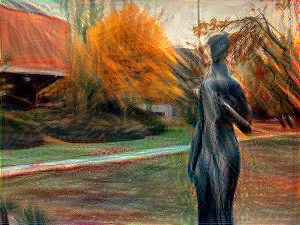

120.951133 seconds (10.96 M allocations: 18.606 GiB, 8.82% gc time)


In [13]:
#Demo: Style transfer.
content_img_def = "content_images/sculpture1.jpg"  #Path of content image i.e. photograph
style_img_def = "style_images/the_scream.jpg"  #Path of style image i.e. artistic painting
iterations = 600  #number of iterations for backpropagation
image_size_default = style_size_default = 300  #new sizes after resizing

content_weights_default = 10*Float64(1.0)   #content loss weights
style_weights_default = 10*Array{Float64}([0.2, 2*0.2, 3*0.2, 4*0.2, 5*0.2])  #style loss weights
tv_weight_def = 8*Float64(1.0) #total variation loss weight

#Choose the layers to extract the content and style representations
#You can choose from the first 26 layers of VGG. The 26th layer is relu5_3. Further layers shouldn't be chosen
content_layer_default = 17    #conv4_2
style_layers_default = (2, 6, 10, 16, 22);  #relu1_1, relu2_1, relu3_1, relu4_1, relu5_1

@time (img1, loss_vector1) = style_transfer(content_img_def, style_img_def, image_size_default, style_size_default, content_layer_default, 
    content_weights_default, style_layers_default, style_weights_default, tv_weight_def);

output1=postprocess(cpu_type(img1));
display(output1)
#Uncomment below code if you want to save.
#save("generated_images/output_image.jpg", output1)